# Connectivity

Traditional multivariate fMRI techniques focus on the information present in patterns of **activity** in localized regions (ROIs or searchlights). Connectivity measures help examine information that may be present across two brain regions, focusing on network interaction rather than spatial localization. When performing connectivity analyses, BOLD timeseries are compared across regions (usually with correlation) and the strength of the connection determines their functional connectivity. By including or excluding stimulus/task variables, we can study the modulation of connectivity by different cognitive states.

We are going to cover connectivity analysis over the next couple exercises, starting today with more basic ROI-level task-based and background connectivity and continuing after break with whole-brain connectivity analyses.  
             
For this script we will use a spatial attention dataset from Hutchinson et al. (in prep) that has been preprocessed with motion correction and linear detrending.

## Goal of this script
>Learn how to run seed-based connectivity analyses.  
>Learn to use an atlas to define seeds.  
>Learn about how stimulus responses impact connectivity.

In [3]:
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import brainiak.utils.fmrisim as sim
from brainiak.fcma.util import compute_correlation
from nilearn import input_data
import time
%matplotlib inline

## Hutchinson et al. (in prep)

The dataset we will be using was collected as part of a recently published study ([Hutchinson et al., 2016, JOCN](https://www.ncbi.nlm.nih.gov/pubmed/26439270)). A paper reporting the application of connectivity analyses to this dataset is being prepared for journal submission. Below find the README file describing the dataset.

**Self-Study:** Explore the data

In [4]:
# Where are the data stored
dir='/gpfs/milgram/data/cmhn-s18/datasets/latatt/'

**Exercise 1**: Carefully read the README file in dir. What are two differences between bg_image and raw_hires?

**A:** bg_image is the standard space average of all subjects' high resolution anatomical images, while raw_hires is the raw high resolution whole brain image for each subject. Therefore, two differences are that (1) bg_image is a single image, while raw_hires is a different image for every subject, and (2) raw_hires is raw, whereas bg_image has been aligned into standard space.

In this dataset, participants attend to a stimulus on either the left or right side of the visual field. We will examine how such spatial attention impacts functional connectivity.

## Data handling

As with previous datasets, let's prepare the preprocessed data for analysis, here of subject #1.

In [5]:
# Where is the data found
dir_time = dir + 'onsets/fsl'  
dir_motion = dir + 'processed_data/motionnuisance/'
dir_motion_global = dir + 'processed_data/motionnuisanceglobal/'

sub= 'sub1'
num_runs=1
TR=1.5
scan_duration = 540

# Shift the data a certain amount
shift_size = 0

We are going to set up the function to allow us to shift the labels to take into consideration the hemodynamic lag. However, we are not actually going to shift the labels here because we care about the build-up in hemodynamic activity which is lost if we implement a lag

In [6]:
# Create a function to shift the labels
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top.
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line.
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

We need to retrieve the labels from the FSL onsets file (the function for doing this is already defined in BrainIAK). Call the function above to set up the data appropriately.

**Self-study:** What does generate_stimfunction do?

In [7]:
# Use the utilities from the simulator to create an event time course based on an FSL onset file

right_stimfunction = sim.generate_stimfunction(onsets='', 
                                               event_durations='', 
                                               total_time=scan_duration,
                                               temporal_resolution=1/TR, 
                                               timing_file=(dir_time + '/%s/right.txt' % (sub)),
                                               )

left_stimfunction  = sim.generate_stimfunction(onsets='', 
                                               event_durations='', 
                                               total_time=scan_duration,
                                               temporal_resolution=1/TR, 
                                               timing_file=(dir_time + '/%s/left.txt' % (sub)),
                                               )

#Shift the timecourses to account for the hemodynamic lag
right_stim_lag = shift_timing(right_stimfunction, shift_size)
left_stim_lag = shift_timing(left_stimfunction, shift_size)

# Get the nifti object
nii = nib.load(dir_motion + '%s.nii.gz' % (sub))

This dataset has two conditions: attend left and attend right. Let's visualize their timecourse.

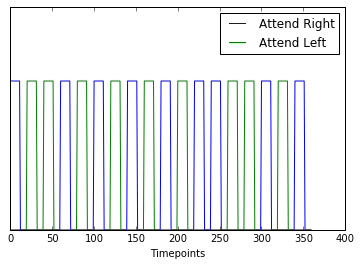

In [8]:
# Plot the stim time course. Assign the second stiumulus a different label (e.g. label =2)
plt.plot(right_stim_lag)
plt.plot(left_stim_lag)
plt.yticks([], '')
plt.xlabel('Timepoints')

plt.legend(('Attend Right', 'Attend Left'),
           loc='upper right')
plt.ylim(0, 1.5)
plt.show()

## Mask the data

Extract all voxels in the whole brain and all timepoints assigned to a condition using the nilearn masking procedure and then z-score the data.

In [9]:
# Create a masker object that also standardizes the data
brain_masker = input_data.NiftiMasker(standardize=True,  # Are you going to zscore the data across time
                                      t_r=1.5, 
                                      memory='nilearn_cache',  # Caches the mask so that it is easier to load and retrieve
                                      memory_level=1,  # How much memory will you cache?
                                      verbose=0,
                                     )

# Pull out the time course for voxel
brain_time_series = brain_masker.fit_transform(nii)
boldWB_rightstim = brain_time_series[(right_stim_lag==1),:]

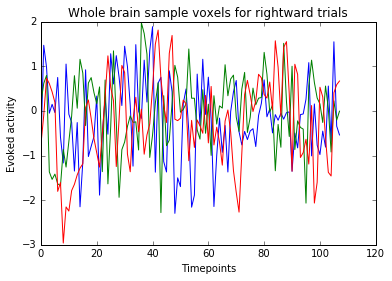

In [10]:
# Plot the timeseries for a few voxels
plt.title('Whole brain sample voxels for rightward trials');
plt.plot(boldWB_rightstim[:,[10, 100, 1000]]);
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');

## Create a spherical ROI

Let's create an ROI to define the parahippocampal place area (PPA), a scene selective region, which is likely important since scene stimuli were presented. The data are currently in MNI space, a standardized anatomical space that allows us to compare individual anatomy to a common, averaged space and use coordinates in MNI space to identify regions (approximately) in individual participants.

**Exercise 2:** [Neurosynth](http://neurosynth.org/) is an excellent resource for determining seeds and ROIs. Go to this website and report the peak coordinates for the two most significant clusters from the search term "Scenes" using reverse inference. We are going to use the peak from the left hemisphere, plug these coordinates into ppa_coords below. What is the difference between voxels that are above threshold for the "reverse inference" analysis compared to the "forward inference" analysis?

**A:**

From http://neurosynth.org/analyses/terms/scenes/:

By increasing the significance threshold, I found that the most significant clusters of voxels are approximately centered on (-24, -46, -10), which is the left PPA, and (30, -42, -12), which is the right PPA.

In brief, the forward inference map displays brain regions that are consistently active in studies that load highly on the term "scenes". Regions with large z-scores are reported more often than one would expect them to be if activation anywhere in the brain was equally likely. Note that this is typically not so interesting, because it turns out that some brain regions are consistently reported in a lot of different kinds of studies (again, see our paper). So as a general rule of thumb, we don't recommend paying much attention to forward inference maps.

Reverse inference maps are, roughly, maps displaying brain regions that are preferentially related to the term scenes. The reverse inference map for scenes displays regions that are reported more often in articles that include the term scenes in their abstracts than articles that do not. Most of the time this a much more useful way of thinking about things, since reverse inference maps tell you, in some sense, which brain regions are more diagnostic of the term in question, and not just which regions are consistently activated in studies associated with that term.

In [11]:
# Specify the center of the ROI
ppa_coords =[(-24, -46, -10)]

Nilearn has some powerful tools for drawing ROIs. These functions allow you to flexibly identify ROIs of any shape and have multiple parameters that allow for smoothing, detrending, filtering and standardization. However, it is easy to get things wrong with these functions so use these parameters cautiously. We will play it safe and use the most basic sphere ROI using the **NiftiSpheresMasker** function from nilearn.

In [12]:
# Create the masking object
seed_masker = input_data.NiftiSpheresMasker(ppa_coords, 
                                            radius=8,
                                            standardize=True,
                                            t_r=2.,
                                            memory='nilearn_cache', 
                                            memory_level=1, 
                                            verbose=0)

# Mask the epi data and get a time series for the ROI
seed_time_series = seed_masker.fit_transform(nii)

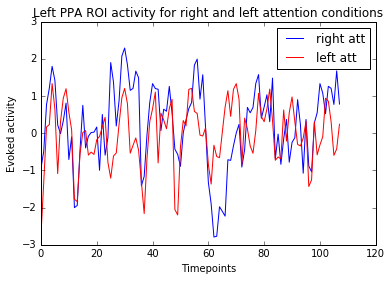

In [13]:
# Plot the data from the seed region for both attention condition
boldSeed_rightstim = seed_time_series[right_stim_lag == 1, :]
boldSeed_leftstim = seed_time_series[left_stim_lag == 1, :]
plt.title('Left PPA ROI activity for right and left attention conditions')
plt.plot(boldSeed_rightstim, 'b');
plt.plot(boldSeed_leftstim, 'r');
plt.legend(('right att', 'left att'));
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');

In [14]:
print("seed time series shape: (%s, %s)" % boldSeed_rightstim.shape)
print("brain time series shape: (%s, %s)" % boldWB_rightstim.shape)

seed time series shape: (108, 1)
brain time series shape: (108, 43642)


## Correlation matrix

We previously encountered correlation matrices in the exercise on pattern similarity. Each cell in those matrices corresponded to the spatial correlation of the pattern of activity for a pair of stimuli or tasks. We will again be using correlation matrices, but now for assessing functional connectivity. Each cell in these matrices reflects the correlation of the BOLD timeseries between a pair of voxels or regions, and matrices can be calculated separately for each condition or even each trial.

Below we go through a slow loop-based way of calculating the correlation of every voxel in the brain with the PPA seed region. We will revisit optimized ways of calculating correlations in the next exercise.

In [15]:
#Correlate seed with every brain voxel. Loop through and extract data for every voxel.
start_time = time.time()
voxels = boldWB_rightstim.shape[1]
all_corr = np.zeros((voxels, 1))
for voxel_counter in range(voxels):    
    corr = np.corrcoef(boldSeed_rightstim[:,0], boldWB_rightstim[:, voxel_counter])[0, 1]
    all_corr[voxel_counter, 0] = corr

end_time = time.time()
print('Analysis duration for %d voxels: %0.2fs' % (voxels, (end_time - start_time)))

Analysis duration for 43642 voxels: 2.82s


We are going to be calculating seed-based correlations throughout this notebook, so let's make a function. It is also common to transform the correlations to a Fisher-Z score, as the bounded nature of Pearson correlation violates certain statistical assumptions. This generally does not have a big effect on the results.

In [16]:
def seed_correlation(wbBold, seedBold):
    voxels = wbBold.shape[1]
    seed_corr = np.zeros((voxels, 1))
    for voxel_counter in range(voxels):    
        seed_corr[voxel_counter, 0] = np.corrcoef(seedBold[:,0], wbBold[:, voxel_counter])[0, 1]
        
    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    
    return seed_corr, seed_corr_fishZ

seed-based correlation Fisher-z transformed: min = -0.655; max = 1.600


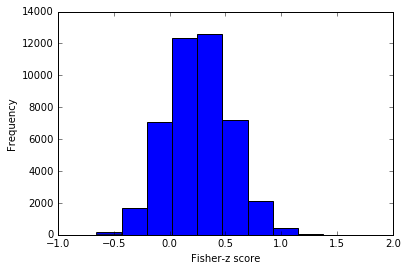

In [17]:
# Let's use it
ppa_rtstim_corr, ppa_rtstim_corr_fz  = seed_correlation(boldWB_rightstim, boldSeed_rightstim)

# Plot the correlation of the seed with every voxel
plt.hist(ppa_rtstim_corr_fz)

print("seed-based correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    ppa_rtstim_corr_fz.min(),
    ppa_rtstim_corr_fz.max()))
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');

In [18]:
# We can tranform the correlation array back to a Nifti image
# object that we can save
ppa_rtstim_corr_img = brain_masker.inverse_transform(ppa_rtstim_corr.T)
ppa_rtstim_corr_img.to_filename('seed_rtstim.nii.gz')

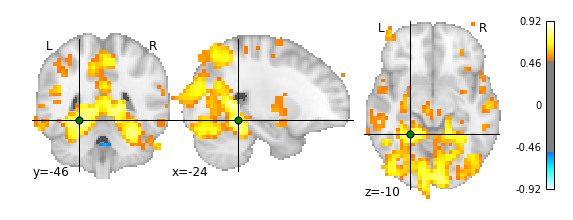

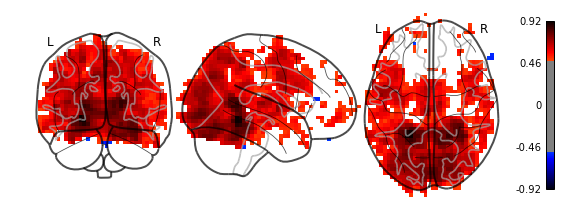

In [19]:
# Nilearn has useful tools for plotting these kinds of masks
h1 = plotting.plot_stat_map(ppa_rtstim_corr_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0])

# Add the seed
h1.add_markers(marker_coords=ppa_coords, 
               marker_color='g',
               marker_size=50)

# Create a glass brain
plotting.plot_glass_brain(ppa_rtstim_corr_img, 
                          threshold=0.5,
                          colorbar=True, 
                          plot_abs=False)

**Exercise 3:** Compute and plot the correlation with the left PPA when participants are attending to the scene in the left visual field.

**Exercise 4:** Create a spherical ROI corresponding to the right PPA from Neurosynth. Compute correlations across the whole brain in both conditions and plot your results.

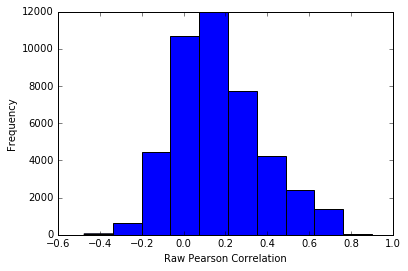

In [20]:
#Exercise 3

boldWB_leftstim = brain_time_series[(left_stim_lag==1),:]
ppa_lfstim_corr, ppa_lfstim_corr_fz  = seed_correlation(boldWB_leftstim, boldSeed_leftstim)

# Plot the correlation of the seed with every voxel
plt.hist(ppa_lfstim_corr)
plt.ylabel('Frequency');
plt.xlabel('Raw Pearson Correlation');

In [21]:
# Exercise 4

right_ppa_coords =[(30, -42, -12)]

# Create the masking object
right_seed_masker = input_data.NiftiSpheresMasker(right_ppa_coords, 
                                            radius=8,
                                            standardize=True,
                                            t_r=2.,
                                            memory='nilearn_cache', 
                                            memory_level=1, 
                                            verbose=0)

# Mask the epi data and get a time series for the ROI
right_seed_time_series = right_seed_masker.fit_transform(nii)

# Extract time series for right PPA
right_boldSeed_rightstim = right_seed_time_series[right_stim_lag == 1, :]
right_boldSeed_leftstim = right_seed_time_series[left_stim_lag == 1, :]

# Extract time series for whole brain in each condition
right_boldWB_rightstim = brain_time_series[(right_stim_lag==1),:]
right_boldWB_leftstim = brain_time_series[(left_stim_lag==1),:]

right_ppa_rtstim_corr, right_ppa_rtstim_corr_fz = seed_correlation(right_boldWB_rightstim, right_boldSeed_rightstim)
right_ppa_lfstim_corr, right_ppa_lfstim_corr_fz = seed_correlation(right_boldWB_leftstim, right_boldSeed_leftstim)

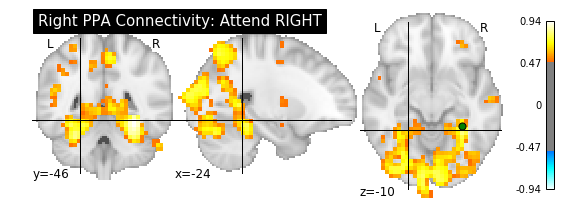

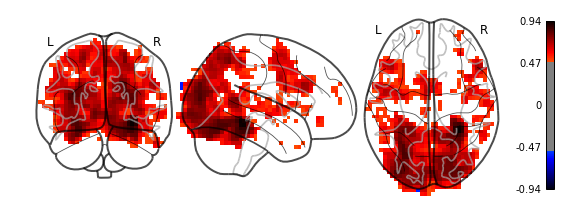

In [22]:
#First, do the right attentional modulation condition

# We can tranform the correlation array back to a Nifti image
# object that we can save
right_ppa_rtstim_corr_img = brain_masker.inverse_transform(right_ppa_rtstim_corr.T)
right_ppa_rtstim_corr_img.to_filename('right_seed_rtstim.nii.gz')

# Nilearn has useful tools for plotting these kinds of masks
h1 = plotting.plot_stat_map(right_ppa_rtstim_corr_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0],
                            title='Right PPA Connectivity: Attend RIGHT')

# Add the seed
h1.add_markers(marker_coords=right_ppa_coords, 
               marker_color='g',
               marker_size=50)

# Create a glass brain
plotting.plot_glass_brain(right_ppa_rtstim_corr_img, 
                          threshold=0.5,
                          colorbar=True, 
                          plot_abs=False)

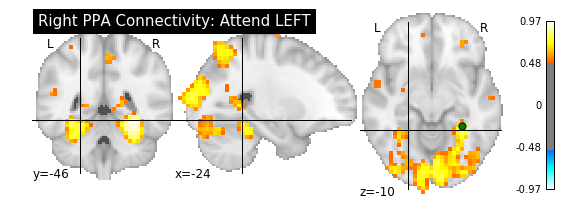

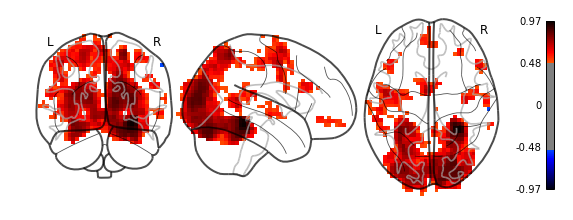

In [23]:
#Now, do it for the left attentional modulation condition

right_ppa_lfstim_corr_img = brain_masker.inverse_transform(right_ppa_lfstim_corr.T)
right_ppa_lfstim_corr_img.to_filename('right_seed_lfstim.nii.gz')

# Nilearn has useful tools for plotting these kinds of masks
h1 = plotting.plot_stat_map(right_ppa_lfstim_corr_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0],
                            title='Right PPA Connectivity: Attend LEFT')

# Add the seed
h1.add_markers(marker_coords=right_ppa_coords, 
               marker_color='g',
               marker_size=50)

# Add title

# Create a glass brain
plotting.plot_glass_brain(right_ppa_lfstim_corr_img, 
                          threshold=0.5,
                          colorbar=True, 
                          plot_abs=False)

## Creating a seed from an atlas

In addition to creating our own seed ROIs, we can use available atlases to extract ROIs and compare correlations. Nilearn provides an easy way to accomplish this. To summarize up front:
1. Use Nilearn to import an atlas parcellation. This will download and save in your home directory by default. 
2. Explore the atlas: plot the different parcels and get their labels.
3. Choose one parcel as the seed and extract BOLD signal from our dataset.
4. Perform correlation.

Atlas path: /home/asl65/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


Harvard-Oxford cortical atlas


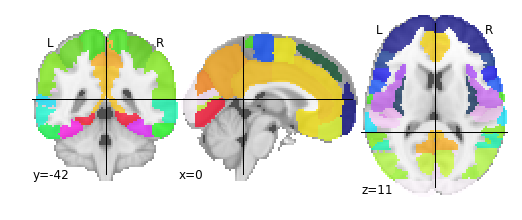

In [24]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# This is where the atlas is saved.
print("Atlas path: " + atlas_filename + "\n\n")

# Create a Pandas dataframe of the atlas data for easy inspection.
atlas_pd = pd.DataFrame(atlas)

# Plot the ROIs
plotting.plot_roi(atlas_filename);
print('Harvard-Oxford cortical atlas')

In [25]:
# Print the labels
# Note that Label #35 is the Parahippocampal Gyrus, posterior division. Label 0 (Background) refers to the brain image, not background connectivity
print(atlas_pd['labels'])

0                                            Background
1                                          Frontal Pole
2                                        Insular Cortex
3                                Superior Frontal Gyrus
4                                  Middle Frontal Gyrus
5             Inferior Frontal Gyrus, pars triangularis
6              Inferior Frontal Gyrus, pars opercularis
7                                      Precentral Gyrus
8                                         Temporal Pole
9            Superior Temporal Gyrus, anterior division
10          Superior Temporal Gyrus, posterior division
11             Middle Temporal Gyrus, anterior division
12            Middle Temporal Gyrus, posterior division
13         Middle Temporal Gyrus, temporooccipital part
14           Inferior Temporal Gyrus, anterior division
15          Inferior Temporal Gyrus, posterior division
16       Inferior Temporal Gyrus, temporooccipital part
17                                    Postcentra

In [26]:
# Create a masker object that we can use to select ROIs

masker = NiftiLabelsMasker(labels_img=atlas_filename)
print(masker)

NiftiLabelsMasker(background_label=0, detrend=False, high_pass=None,
         labels_img='/home/asl65/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
         low_pass=None, mask_img=None, memory=Memory(cachedir=None),
         memory_level=1, resampling_target='data', smoothing_fwhm=None,
         standardize=False, t_r=None, verbose=0)


In previous analyses we calculated the average activity in a single seed region across time. However, Nilearn has tools to easily calculate the timecourse of activity across all of the ROIs that are supplied to the masker object.

In [27]:
parcel_time_series = masker.fit_transform(nii)
boldParcel_rightstim = parcel_time_series[(right_stim_lag==1),:]
print("Parcellated dimensionality: %d timepoints by %d ROIs" % parcel_time_series.shape)
print("Parcellated dimensionality for rightward attention: %d timepoints by %d ROIs" % boldParcel_rightstim.shape)

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:435: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter will change in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


Parcellated dimensionality: 360 timepoints by 48 ROIs
Parcellated dimensionality for rightward attention: 108 timepoints by 48 ROIs


(108, 1)


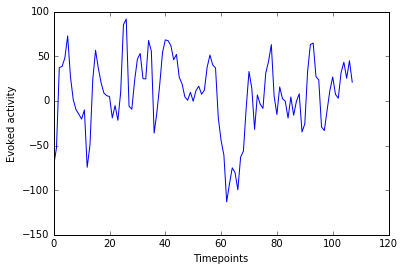

In [28]:
# Pull out a single ROI corresponding to the parahippocampal cortex

boldAtlasSeed_rightstim = np.array(boldParcel_rightstim[:, 35])
boldAtlasSeed_rightstim = boldAtlasSeed_rightstim.reshape(boldAtlasSeed_rightstim.shape[0],-1)
print(boldAtlasSeed_rightstim.shape)
plt.figure()
plt.plot(boldAtlasSeed_rightstim)
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');

PHG correlation Fisher-z transformed: min = -0.640; max = 1.609


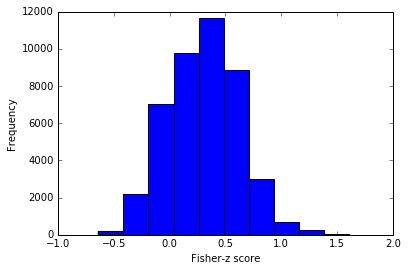

In [29]:
# Like before we want to correlate the whole brain time course with the seed we have pulled out
phg_corr_rtstim, phg_corr_rtstim_fz = seed_correlation(boldWB_rightstim, boldAtlasSeed_rightstim) 

plt.hist(phg_corr_rtstim_fz)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');

print("PHG correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    phg_corr_rtstim_fz.min(),
    phg_corr_rtstim_fz.max()))

# Save the nifti image
phg_corr_rtstim_fz_img = brain_masker.inverse_transform(
    phg_corr_rtstim_fz.T)
phg_corr_rtstim_fz_img.to_filename('sbc_z.nii.gz')

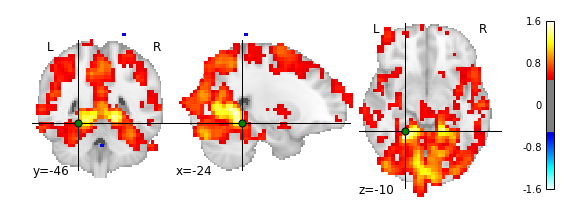

In [30]:
# For comparison, we plot the position of the sphere we created ealier.
h2 = plotting.plot_stat_map(phg_corr_rtstim_fz_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0], 
                           )
h2.add_markers(marker_coords=ppa_coords, 
               marker_color='g',
               marker_size=50)

## Compute connectivity across parcels

In addition to one ROI, we can compute correlations across multiple brain regions. Nilearn has a function to do this quite easily.

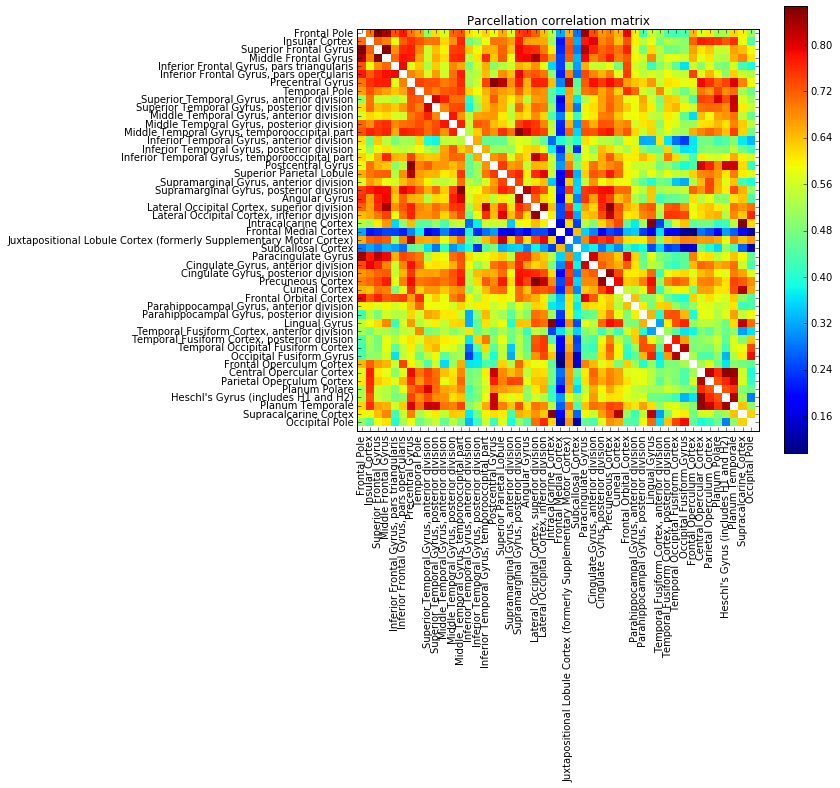

In [31]:
# Set up the connectivity object
correlation_measure = ConnectivityMeasure(kind='correlation')

# Calculate the correlation of each parcel with every other parcel
correlation_matrix = correlation_measure.fit_transform([boldParcel_rightstim])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(correlation_matrix, np.nan)

# Plot the correlation matrix
fig=plt.figure(figsize=(9,8))

# The labels we have start with the background (0), hence we skip the
# first label
plt.imshow(correlation_matrix, interpolation='None')
plt.yticks(range(len(atlas.labels)), atlas.labels[1:]);
plt.xticks(range(len(atlas.labels)), atlas.labels[1:], rotation=90);
plt.title('Parcellation correlation matrix')
plt.colorbar()


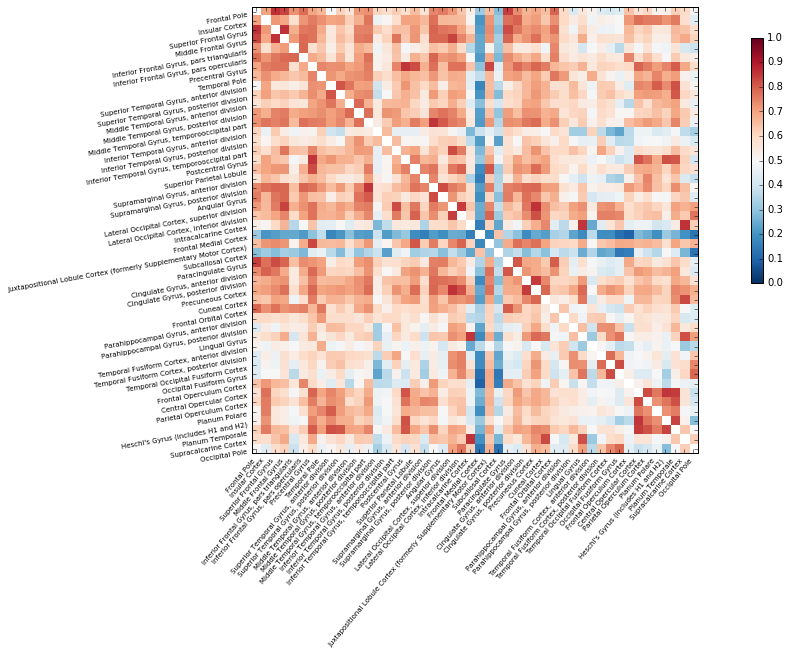

In [32]:
# Nilearn has its own plotting function too
plotting.plot_matrix(correlation_matrix, 
                     figure=(10, 8), 
                     labels=atlas.labels[1:],
                     vmax=1, 
                     vmin=0)

**Exercise 5:** Use a parcel from the parietal lobe as a seed and compute the **voxelwise** correlation across the brain for the attend left and attend right conditions. Are there any connectivity differences between these conditions? Remember this is only one subject and so it is difficult to test this statistically.

In [33]:
# Exercise 5

boldParcel_leftstim = parcel_time_series[(left_stim_lag==1),:]

# Pull out a single ROI corresponding to the superior parietal lobule

boldAtlasSeed_rightstim = np.array(boldParcel_rightstim[:, 18])
boldAtlasSeed_rightstim = boldAtlasSeed_rightstim.reshape(boldAtlasSeed_rightstim.shape[0],-1)

boldAtlasSeed_leftstim = np.array(boldParcel_leftstim[:, 18])
boldAtlasSeed_leftstim = boldAtlasSeed_leftstim.reshape(boldAtlasSeed_leftstim.shape[0],-1)

# Like before we want to correlate the whole brain time course with the seed we have pulled out
spl_corr_rtstim, spl_corr_rtstim_fz = seed_correlation(boldWB_rightstim, boldAtlasSeed_rightstim) 
spl_corr_lfstim, spl_corr_lfstim_fz = seed_correlation(boldWB_leftstim, boldAtlasSeed_leftstim)

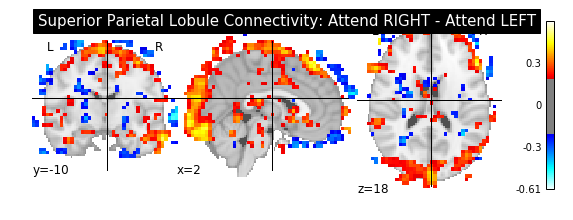

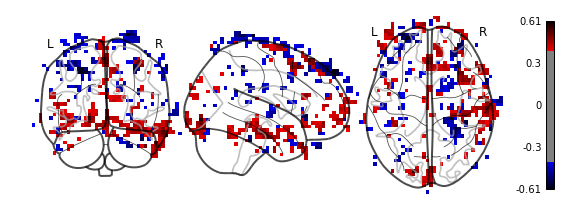

In [34]:
# Take the difference between voxelwise correlations
spl_corr_right_minus_left = spl_corr_rtstim - spl_corr_lfstim

# Perform inverse transform on difference in correlations
spl_diff_stim_corr_img = brain_masker.inverse_transform(spl_corr_right_minus_left.T)
spl_diff_stim_corr_img.to_filename('spl_seed_diff_stim.nii.gz')

# Nilearn has useful tools for plotting these kinds of masks
h4 = plotting.plot_stat_map(spl_diff_stim_corr_img, 
                            threshold=0.2,
                            title='Superior Parietal Lobule Connectivity: Attend RIGHT - Attend LEFT')

# Create a glass brain
plotting.plot_glass_brain(spl_diff_stim_corr_img, 
                          threshold=0.4,
                          colorbar=True, 
                          plot_abs=False)

# Since the effect you're looking for is an interaction between left and right
# hemispheres/attentional conditions, a bilateral seed doesn't help us here.

## Background connectivity

Now let us examine the connectivity after removing stimulus confounds. The dataset in the directory motionnuisanceglobal has already had the evoked activity regressed out in FSL with a GLM. We'll repeat the previous analyses for the left PPA on these data.

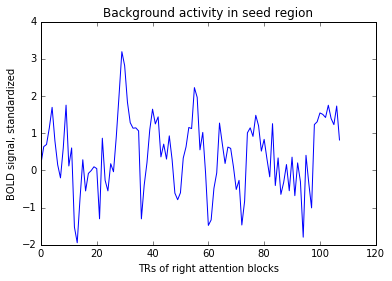

In [35]:
# Load in the data
epi_in_mcg = (dir_motion_global + '%s.nii.gz' % (sub))
seed_time_series_mcg= seed_masker.fit_transform(epi_in_mcg)
boldSeed_rtstim_mcg = seed_time_series_mcg[right_stim_lag==1,:]
boldWB_mcg = brain_masker.fit_transform(epi_in_mcg)
boldWB_rtstim_mcg = boldWB_mcg[right_stim_lag==1,:] 

# plot the data
plt.plot(boldSeed_rtstim_mcg)
plt.ylabel('BOLD signal, standardized')
plt.xlabel('TRs of right attention blocks')
plt.title('Background activity in seed region')

In [36]:
# Calculate the voxelwise seed-based correlation
ppa_corr_rtstim_mcg, ppa_corr_rtstim_fz_mcg  = seed_correlation(boldWB_rtstim_mcg, boldSeed_rtstim_mcg)

print("PHG correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    ppa_corr_rtstim_fz_mcg.min(),
    ppa_corr_rtstim_fz_mcg.max()))


PHG correlation Fisher-z transformed: min = -0.768; max = 1.365


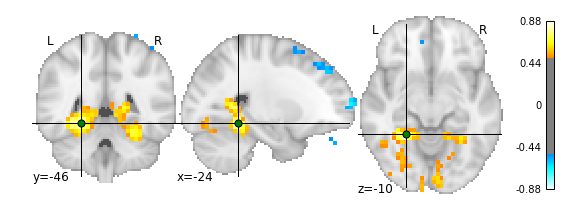

In [37]:
# Plot the correlation of each voxel in the brain with the seed
ppa_corr_rtstim_mcg_img = brain_masker.inverse_transform(ppa_corr_rtstim_mcg.T)
h3 = plotting.plot_stat_map(ppa_corr_rtstim_mcg_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0])
h3.add_markers(marker_coords=ppa_coords, 
               marker_color='g',
               marker_size=50)

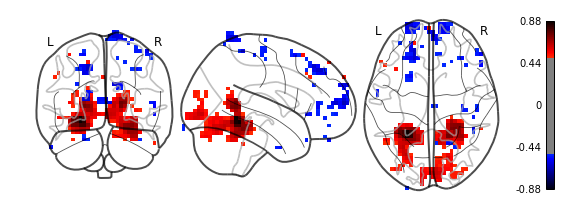

In [38]:
plotting.plot_glass_brain(ppa_corr_rtstim_mcg_img, 
                          threshold=0.5,
                          colorbar=True, 
                          plot_abs=False)

**Exercise 6:** Compare background connectivity to the original left PPA spherical ROI result. Why is there less and cleaner connectivity overall?

The background connectivity removes the evoked responses in each region. Therefore, regions that are driven by stimuli alone (e.g. PPA and early visual areas) don't necessarily show high correlation in the background connectivity analysis. Instead, we perform our analysis on the residuals from an evoked response model and can find specifically those regions where the "noise" is correlated, meaning that there is an effect of functional connectivity over and above the effect of co-driven inputs.

In [39]:
# Parcellate the time course to get the background connectivity parcels
parcel_time_series_mcg = masker.fit_transform(epi_in_mcg)
boldParcel_rightstim_mcg = parcel_time_series_mcg[right_stim_lag==1, :]

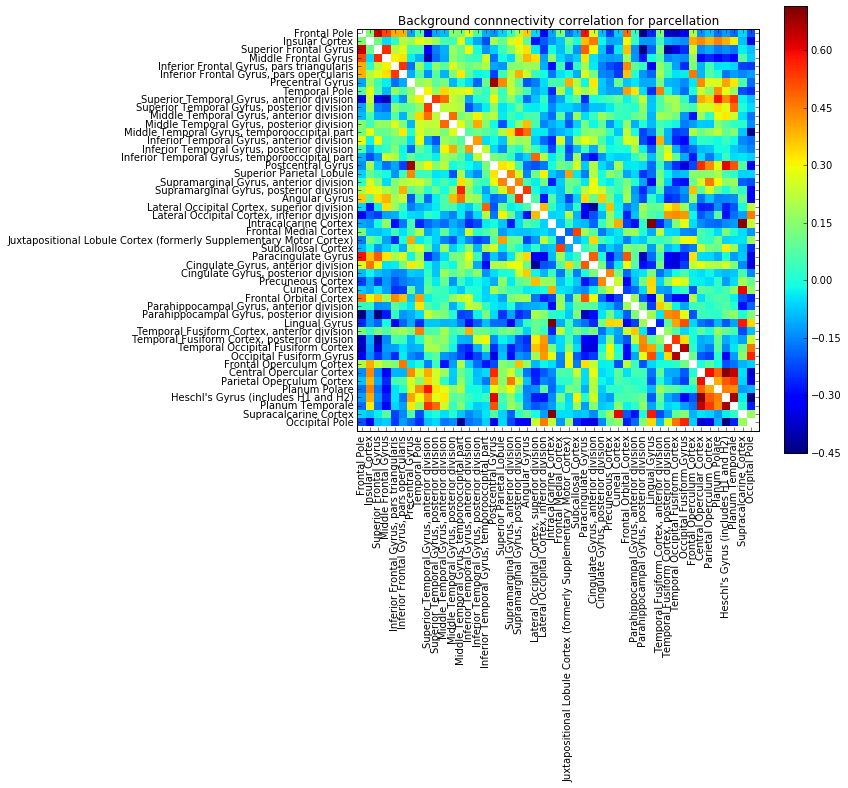

In [40]:
correlation_matrix_mcg = correlation_measure.fit_transform([boldParcel_rightstim_mcg])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(correlation_matrix_mcg, np.nan)

# Plot the correlation matrix
fig=plt.figure(figsize=(9,8))

# The labels we have start with the background (0), hence we skip the
# first label
plt.title('Background connnectivity correlation for parcellation')
plt.imshow(correlation_matrix_mcg, interpolation='None')
plt.yticks(range(len(atlas.labels)), atlas.labels[1:]);
plt.xticks(range(len(atlas.labels)), atlas.labels[1:], rotation=90);
plt.colorbar()

**Exercise 7:** Use a different atlas (use "datasets.fetch\_" and look through other available atlases) and recompute the background connectivity matrix for both attend left and attend right conditions. Use an atlas that distinguishes ROIs between the left and right hemispheres and rearrange the labels so that all the ROIs from a hemisphere are grouped. Why might it be important to separate the hemispheres?

Atlas path: /home/asl65/nilearn_data/aal_SPM12/aal/atlas/AAL.nii


AAL Cortical Atlas


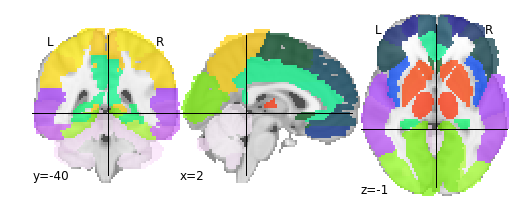

In [41]:
# Exercise 7

atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps

# This is where the atlas is saved.
print("Atlas path: " + atlas_filename + "\n\n")

# Create a Pandas dataframe of the atlas data for easy inspection.
atlas_pd = pd.DataFrame(atlas)

# Plot the ROIs
plotting.plot_roi(atlas_filename);
print('AAL Cortical Atlas')

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:435: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter will change in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


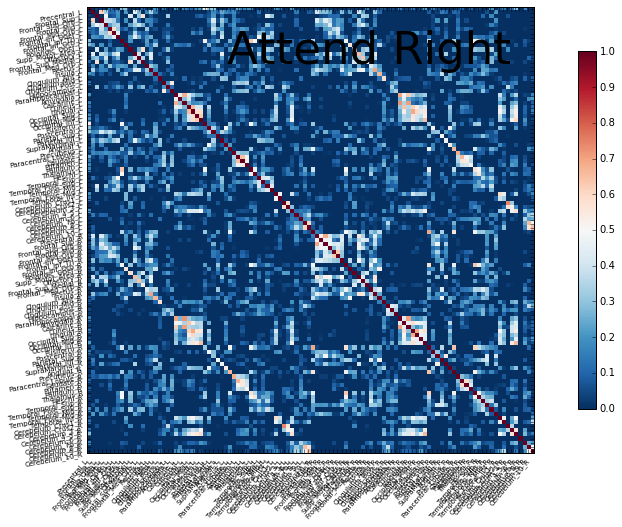

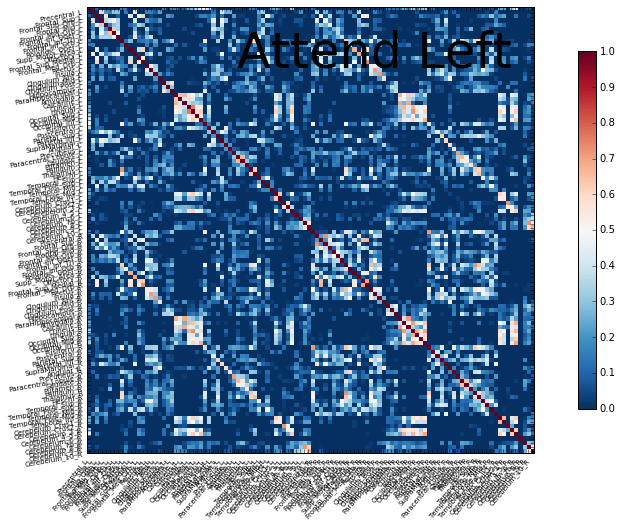

In [42]:
# Print the labels
# print(atlas_pd['labels'])

# Create a masker object that we can use to select ROIs
masker = NiftiLabelsMasker(labels_img=atlas_filename)
parcel_time_series = masker.fit_transform(epi_in_mcg)

# Group by hemisphere
reordered_indices = list(range(0, 108, 2)) + list(range(1, 108, 2))
boldParcel_rightstim = parcel_time_series[(right_stim_lag==1),:]
boldParcel_rightstim = boldParcel_rightstim[:, reordered_indices]
boldParcel_leftstim = parcel_time_series[(left_stim_lag==1),:]
boldParcel_leftstim = boldParcel_leftstim[:, reordered_indices]

reordered_labels = np.array(atlas.labels)[reordered_indices]

# Calculate the correlation of each parcel with every other parcel
right_correlation_matrix = correlation_measure.fit_transform([boldParcel_rightstim])[0]
left_correlation_matrix = correlation_measure.fit_transform([boldParcel_leftstim])[0]

# Nilearn has its own plotting function too
plotting.plot_matrix(right_correlation_matrix, 
                     figure=(10, 8), 
                     labels=reordered_labels,
                     vmax=1, 
                     vmin=0,
                     title='Attend Right')

plotting.plot_matrix(left_correlation_matrix, 
                     figure=(10, 8), 
                     labels=reordered_labels,
                     vmax=1, 
                     vmin=0,
                     title='Attend Left')

**Exercise 8:** Calculate and store the two matrices above (one for each attention condition) for all 30 participants. Plot the average across participants for each condition.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:435: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter will change in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


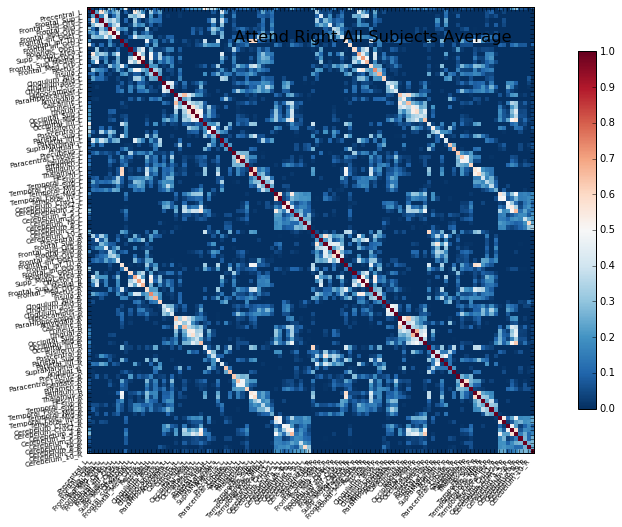

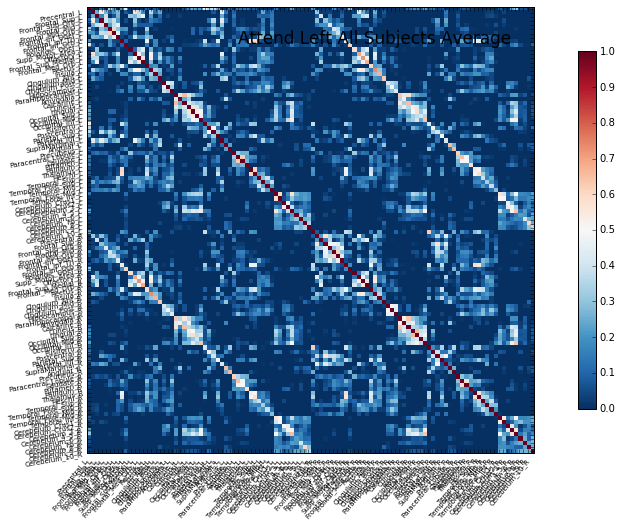

In [43]:
# Exercise 8

N_SUBJ = 30
N_PARCELS = len(reordered_indices)

# Create a masker object that we can use to select ROIs
masker = NiftiLabelsMasker(labels_img=atlas_filename)

right_correlation_matrices = np.zeros((N_SUBJ, N_PARCELS, N_PARCELS))
left_correlation_matrices = np.zeros((N_SUBJ, N_PARCELS, N_PARCELS))
    
for i in range(N_SUBJ):
    
    # Naming convention
    sub = 'sub' + str(i+1)
    
    #Shift the timecourses to account for the hemodynamic lag
    right_stim_lag = shift_timing(right_stimfunction, shift_size)
    left_stim_lag = shift_timing(left_stimfunction, shift_size)
    
    # Load in the data
    epi_in_mcg = (dir_motion_global + '%s.nii.gz' % (sub))
    
    # Parcellate the time course to get the background connectivity parcels
    parcel_time_series_mcg = masker.fit_transform(epi_in_mcg)
    
    boldParcel_rightstim_mcg = parcel_time_series_mcg[right_stim_lag==1, :]
    boldParcel_rightstim_mcg = boldParcel_rightstim_mcg[:, reordered_indices]
    
    boldParcel_leftstim_mcg = parcel_time_series_mcg[left_stim_lag==1, :]
    boldParcel_leftstim_mcg = boldParcel_leftstim_mcg[:, reordered_indices]
    
    # Calculate the correlation of each parcel with every other parcel
    right_correlation_matrix = correlation_measure.fit_transform([boldParcel_rightstim_mcg])[0]
    right_correlation_matrices[i, :, :] = np.asarray(right_correlation_matrix, dtype=np.float)
    left_correlation_matrix = correlation_measure.fit_transform([boldParcel_leftstim_mcg])[0]
    left_correlation_matrices[i, :, :] = np.asarray(left_correlation_matrix, dtype=np.float)
    
right_means = np.mean(right_correlation_matrices, axis=0)
left_means = np.mean(left_correlation_matrices, axis=0)

plotting.plot_matrix(right_means, 
                     figure=(10, 8), 
                     labels=reordered_labels,
                     vmax=1, 
                     vmin=0,
                     title='Attend Right All Subjects Average')

plotting.plot_matrix(left_means, 
                     figure=(10, 8), 
                     labels=reordered_labels,
                     vmax=1, 
                     vmin=0,
                     title='Attend Left All Subjects Average')

**Exercise 9:** For each participant, calculate the difference between their matrix for left attention and the matrix for right attention. You should now have 30 difference matrices. This allows you to conduct a simple statistical test of how reliably left vs. right attention affects background connectivity between parcels in the sample. We will use a one-sample t-test for this purpose, which requires two inputs: (1) the average difference matrix across participants and (2) the standard error of the difference matrix across participants (standard deviation matrix divided by root N). Compute and plot a t-statistic matrix by dividing the average difference matrix by the standard error matrix. Summarize in words which regions' connectivity (if any) distinguish attention conditions.

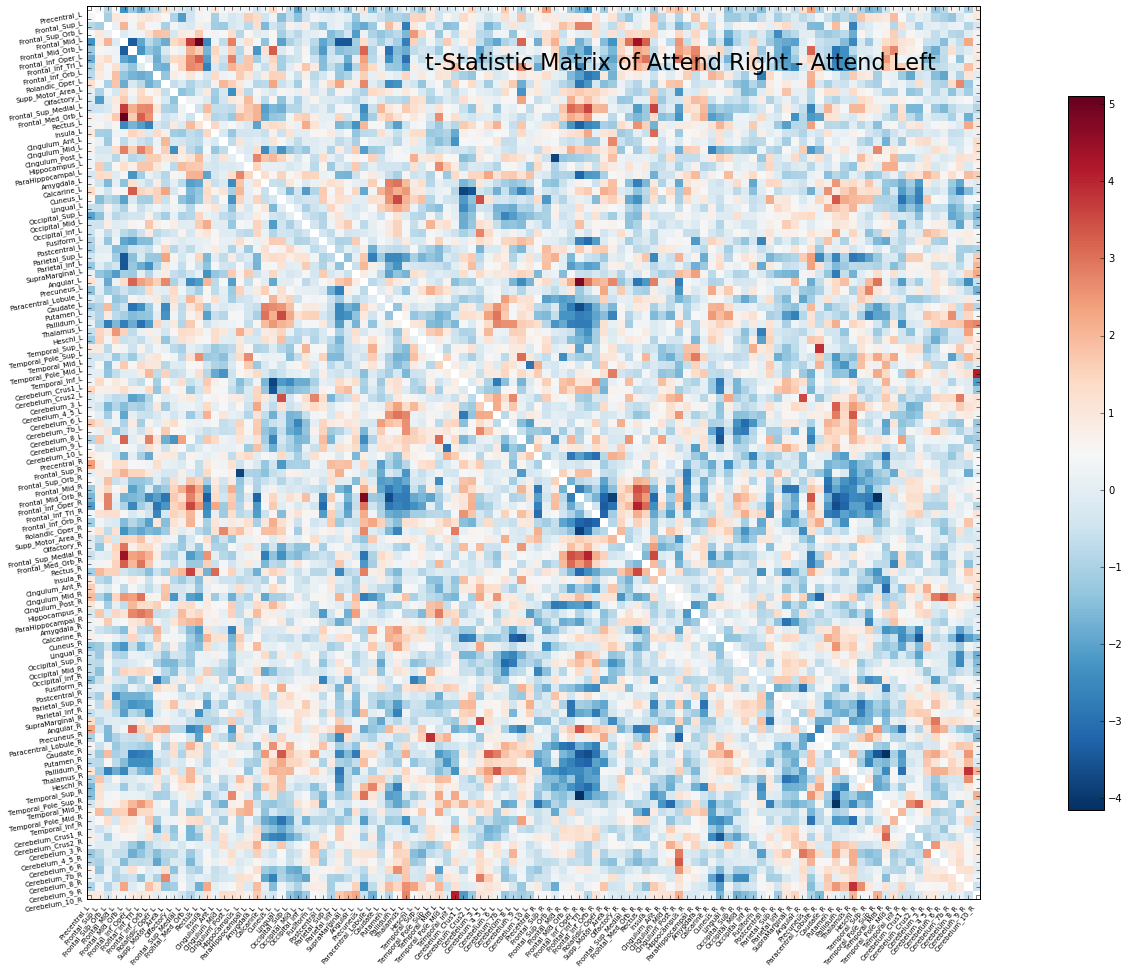

In [48]:
diff_matrices = np.subtract(right_correlation_matrices, left_correlation_matrices)
avg_diff_matrix = np.mean(diff_matrices, axis=0)
stdev_diff_matrix = np.std(diff_matrices, axis=0)
stderror_diff_matrix = np.divide(stdev_diff_matrix, np.sqrt(N_SUBJ))
tstat_matrix = np.divide(avg_diff_matrix, stderror_diff_matrix)
plotting.plot_matrix(tstat_matrix, 
                     figure=(20, 16), 
                     labels=reordered_labels,
                     title='t-Statistic Matrix of Attend Right - Attend Left')

# There is a lot of alternation between blue and red (high positive connectivity and high negative connectivity) 
# in frontal regions such as the frontal operculum, and also some temporal areas such as the temporal pole. This
# matches nicely with the role of frontal cortex in attentional modulation.

**Novel contribution:** be creative and make one new discovery by adding an analysis, visualization, or optimization.

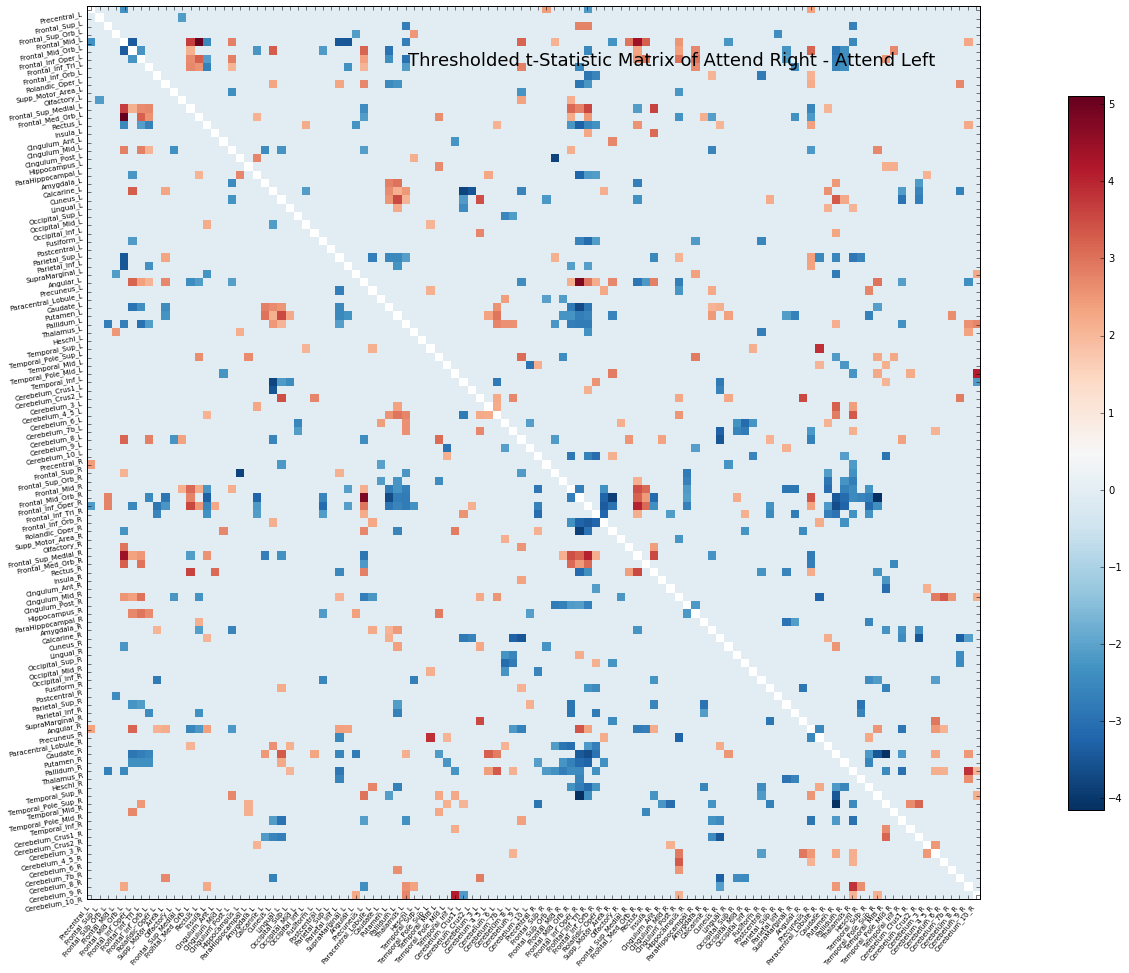

In [51]:
# Threshold the matrix of t values at p < 0.05 (two-tailed). For 30 subjects, df = 29 and so t > 2.05

thresh = 2.05
tstat_thresh_matrix = np.copy(tstat_matrix)
sub_threshold_indices = np.abs(tstat_matrix) <= thresh
tstat_thresh_matrix[sub_threshold_indices] = 0
plotting.plot_matrix(tstat_thresh_matrix, 
                     figure=(20, 16), 
                     labels=reordered_labels,
                     title='Thresholded t-Statistic Matrix of Attend Right - Attend Left')